In [1]:
import torch
from unet_model import UNet
from dataset import color_name_to_tensor
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet().to(device)
model.load_state_dict(torch.load("best_unet.pth", map_location=device))
model.eval()


UNet(
  (in_conv): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [4]:
with open("dataset/validation/data.json", "r") as f:
    val_data = json.load(f)

# Pick a sample
sample = val_data[0]
polygon_path = f"dataset/validation/inputs/{sample['input_polygon']}" # Corrected path and key
output_path = f"dataset/validation/outputs/{sample['output_image']}" # Corrected path and key
color_name = sample['colour']

In [6]:
# Load and preprocess the input
polygon = Image.open(polygon_path).convert("L")
polygon = np.array(polygon, dtype=np.float32) / 255.0
polygon_tensor = torch.tensor(polygon).unsqueeze(0)  # [1, H, W]

H, W = polygon_tensor.shape[1], polygon_tensor.shape[2]
color_tensor = color_name_to_tensor(color_name, H, W)

input_tensor = torch.cat([polygon_tensor, color_tensor], dim=0).unsqueeze(0)  # [1, 4, H, W]

In [7]:
with torch.no_grad():
    input_tensor = input_tensor.to(device)
    output_tensor = model(input_tensor)
    output_image = output_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09723272..1.1286238].


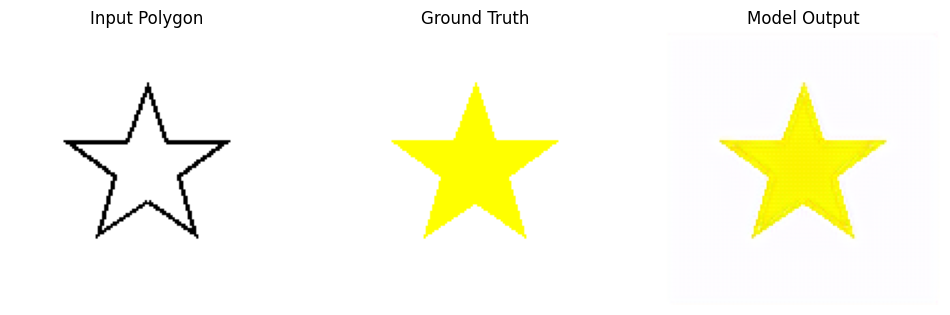

In [8]:
# Load ground truth image
gt = Image.open(output_path).convert("RGB")
gt = np.array(gt, dtype=np.float32) / 255.0

# Input grayscale
input_gray = polygon_tensor.squeeze(0).numpy()

# Plot all
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Polygon")
plt.imshow(input_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(gt)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Model Output")
plt.imshow(output_image)
plt.axis('off')

plt.show()
